In [35]:
import re
import string
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import os

from __future__ import print_function
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
import logging
from numpy import random
import gensim

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, MaxPooling1D, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras import initializers, regularizers, constraints
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Layer
import keras.backend
from keras.models import Sequential, load_model
from tensorflow.compat.v1.keras.layers import CuDNNGRU
from keras.layers import Dense, Conv1D, MaxPooling1D
from keras.layers import Dropout, GlobalMaxPooling1D, BatchNormalization, LSTM
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras.optimizers import Nadam
from keras.utils import plot_model
import matplotlib.pyplot as plt

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, concatenate
from keras.layers import concatenate
from keras.models import Model
import keras.backend
from keras.models import Sequential, load_model
from tensorflow.compat.v1.keras.layers import CuDNNGRU
from keras.layers import Dense, Conv1D, MaxPooling1D
from keras.layers import Dropout, GlobalMaxPooling1D, BatchNormalization, LSTM
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras.optimizers import Nadam
from keras.utils import plot_model
import matplotlib.pyplot as plt
from keras import backend as K
from keras.callbacks import ModelCheckpoint

## Download Data from Kaggle

In [29]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("rtatman/deceptive-opinion-spam-corpus")

# print("Path to dataset files:", path)

# # Download latest version
# path = kagglehub.dataset_download("rtatman/glove-global-vectors-for-word-representation")

# print("Path to dataset files:", path)

100%|████████████████████████████████████████| 458M/458M [00:14<00:00, 34.1MB/s]

Extracting files...


Path to dataset files: /Users/sylviaz/.cache/kagglehub/datasets/rtatman/glove-global-vectors-for-word-representation/versions/1


## Data Preprocess

In [3]:
df = pd.read_csv('./kaggle/input/rtatman/deceptive-opinion-spam-corpus/deceptive-opinion.csv')
df = df.drop(["hotel", "polarity","source"], axis=1)
df = df.sample(frac=1)
df.head()

,deceptive,text
1499,deceptive,Sofitel not-so-luxury Hotels I recently checke...
412,deceptive,Luxury and comfort combine to give a wonderful...
376,truthful,"We stayed for just one night ,but the hotel st..."
953,truthful,"This hotel had a great location, but you can d..."
548,deceptive,My boyfriend and I wanted to spend a four-day ...


In [6]:
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 

# Encode labels in column 'species'. 
df['deceptive']= label_encoder.fit_transform(df['deceptive']) 

df['deceptive'].unique() 

#dataset description #truthful=1 deceptive=0
df.groupby('deceptive').describe()

text                                                               
          count unique                                                top freq
deceptive                                                                     
0           800    800  Sofitel not-so-luxury Hotels I recently checke...    1
1           800    796  I'd been searching for a cool, non-chain hotel...    2

In [7]:
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)

    return text

# Some preprocesssing that will be common to all the text classification methods

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_char(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [8]:
df['text'] = df['text'].map(lambda a: clean_numbers(a))
df['text'] = df['text'].map(lambda a: clean_char(a))
df['text'] = df['text'].map(lambda a: clean_text(a))

In [9]:
df.describe()

,deceptive
count,1600.000000
mean,0.500000
std,0.500156
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 1499 to 1124
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   deceptive  1600 non-null   int64 
 1   text       1600 non-null   object
dtypes: int64(1), object(1)
memory usage: 37.5+ KB


In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['deceptive'], random_state=5)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 1600
Number of rows in the training set: 1200
Number of rows in the test set: 400


In [15]:
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer()

training_data = count_vector.fit_transform(X_train)
testing_data = count_vector.transform(X_test)

## Model Training

### Logistic Regression - Baseline

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(training_data, y_train)
lrpredicted = lr.predict(testing_data)

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
lr_accuracy = accuracy_score(lrpredicted, y_test )
print('Accuracy score: ', format(accuracy_score(lrpredicted, y_test)))
print('Precision score: ', format(precision_score(y_test, lrpredicted)))
print('Recall score: ', format(recall_score(y_test, lrpredicted)))
print('F1 score: ', format(f1_score(y_test, lrpredicted)))

Accuracy score:  0.8525
Precision score:  0.875
Recall score:  0.8275862068965517
F1 score:  0.8506329113924052


### Attention-based bidirectional LSTM

In [23]:
X = df['text']
y = df['deceptive']

In [25]:
tokenizer = Tokenizer(num_words=None,lower=True,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',split=' ',char_level=False)
tokenizer.fit_on_texts(X)
x_train = tokenizer.texts_to_sequences(X_train)
x_test = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index
X = tokenizer.texts_to_sequences(X)

vocab_size = len(word_index)
print('Vocab size: {}'.format(vocab_size))
longest = max(len(seq) for seq in X)
print("Longest comment size: {}".format(longest))
average = np.mean([len(seq) for seq in X])
print("Average comment size: {}".format(average))
stdev = np.std([len(seq) for seq in X])
print("Stdev of comment size: {}".format(stdev))
max_len = int(average + stdev * 3)
print('Max comment size: {}'.format(max_len))

Vocab size: 6224
Longest comment size: 371
Average comment size: 71.258125
Stdev of comment size: 41.07383895479427
Max comment size: 194


In [28]:
from tensorflow.keras.layers import Layer
import keras.backend
from keras.models import Sequential, load_model
from tensorflow.compat.v1.keras.layers import CuDNNGRU
from keras.layers import Dense, Conv1D, MaxPooling1D
from keras.layers import Dropout, GlobalMaxPooling1D, BatchNormalization, LSTM
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras.optimizers import Nadam
from keras.utils import plot_model
import matplotlib.pyplot as plt

In [27]:
processed_post_x_train = pad_sequences(x_train, maxlen=max_len, padding='post', truncating='post')
processed_post_x_test = pad_sequences(x_test, maxlen=max_len, padding='post', truncating='post')
processed_x_train = pad_sequences(x_train, maxlen=max_len)
processed_x_test = pad_sequences(x_test, maxlen=max_len)
processed_pre_x_train = pad_sequences(x_train, maxlen=max_len)
processed_pre_x_test = pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', processed_x_train.shape)
print('x_test shape:', processed_x_test.shape)

x_train shape: (1200, 194)
x_test shape: (400, 194)


In [32]:
embeddings_index = {}
f = open(os.path.join('./kaggle/input/rtatman/glove-global-vectors-for-word-representation', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [33]:
embedding_dim = 100
k = 0
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        k += 1
        embedding_matrix[i] = embedding_vector

In [36]:
class Attention(keras.layers.Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.supports_masking = True
        #self.init = initializations.get('glorot_uniform')
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        # eij = K.dot(x, self.W) TF backend doesn't support it

        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
    #print weigthted_input.shape
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim
    
def get_model():
    review_input = Input(shape=(max_len,), dtype='int32')
    review_input_post = Input(shape=(max_len,), dtype='int32')

    x1 = Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(review_input)
    x1 = Bidirectional(LSTM(60, return_sequences=True))(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Attention(max_len)(x1)

    x2 = Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(review_input_post)
    x2 = Bidirectional(LSTM(60, return_sequences=True))(x2)
    x2 = Dropout(0.3)(x2)
    x2 = Attention(max_len)(x2)

    x = concatenate([x1, x2])
    x = Dense(50, activation='relu')(x)
    x= Dropout(0.2)(x)
    x = BatchNormalization()(x)
    preds = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[review_input, review_input_post], outputs=preds)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [42]:
model = get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 194)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 194)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 194, 100)             622500    ['input_3[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 194, 100)             622500    ['input_4[0][0]']             
                                                                                            

In [43]:
# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Epoch 1/10
38/38 [==============================] - 24s 439ms/step - loss: 0.6819 - accuracy: 0.5758 - val_loss: 0.6796 - val_accuracy: 0.6775
Epoch 2/10
38/38 [==============================] - 14s 375ms/step - loss: 0.4926 - accuracy: 0.7733 - val_loss: 0.6169 - val_accuracy: 0.7825
Epoch 3/10
38/38 [==============================] - 16s 411ms/step - loss: 0.3401 - accuracy: 0.8667 - val_loss: 0.5225 - val_accuracy: 0.7350
Epoch 4/10
38/38 [==============================] - 15s 382ms/step - loss: 0.1895 - accuracy: 0.9367 - val_loss: 0.4741 - val_accuracy: 0.7875
Epoch 5/10
38/38 [==============================] - 14s 362ms/step - loss: 0.1501 - accuracy: 0.9525 - val_loss: 0.4395 - val_accuracy: 0.8175
Epoch 6/10
38/38 [==============================] - 14s 372ms/step - loss: 0.0672 - accuracy: 0.9792 - val_loss: 0.4221 - val_accuracy: 0.7975
Epoch 7/10
38/38 [==============================] - 15s 393ms/step - loss: 0.0532 - accuracy: 0.9883 - val_loss: 0.4808 - val_accuracy: 0.8175

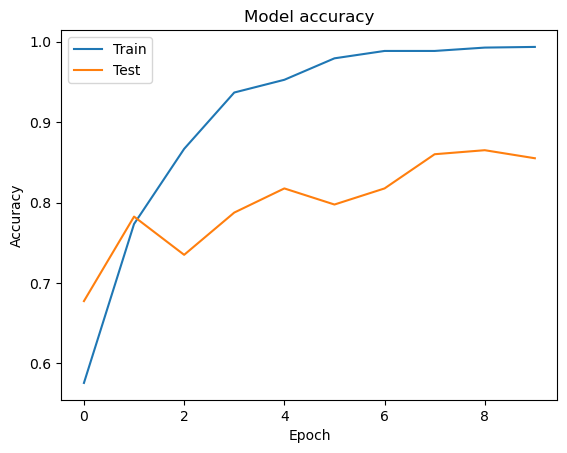

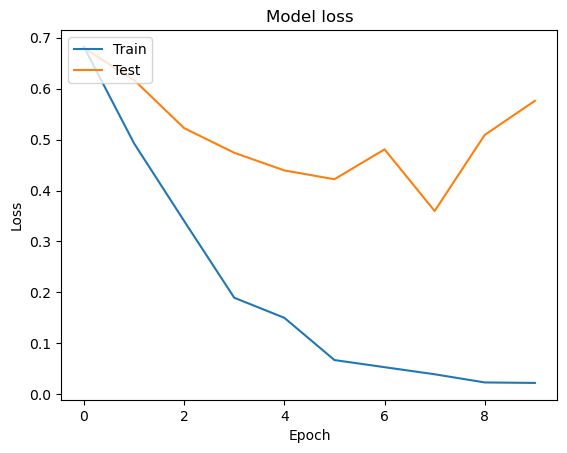

In [44]:
early_stopping_monitor = EarlyStopping(patience=10)
history = model.fit([processed_x_train,processed_pre_x_train],y_train, validation_data=([processed_x_test,processed_pre_x_test],y_test), epochs=10,batch_size=32,callbacks=[early_stopping_monitor],verbose=1)
model.evaluate([processed_x_test,processed_pre_x_test],y_test)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])  # Change 'acc' to 'accuracy'
plt.plot(history.history['val_accuracy'])  # Change 'val_acc' to 'val_accuracy'
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
